# 💳 Task 3 – Proxy Label Engineering & Behavioral Risk Feature Creation  
📘 Version: 2025-07-01  

This notebook designs and implements a **proxy risk labeling framework** for **Bati Bank’s BNPL Credit Scoring Initiative**.  
It combines statistical hypothesis testing, behavioral risk segmentation, and rule-based label creation to generate the target variable (`is_high_risk`) required for model training (**Task 5**) and explainability (**Task 6**).  

Outputs from this notebook will directly inform:
- The development of a **credit risk model** to predict the likelihood of default or delinquency.
- The creation of defensible risk categories to support **loan decisioning** and **credit policy design**.

---

**Challenge:** B5W5 – Credit Scoring & Risk Modeling  
**Company:** Bati Bank (in partnership with an eCommerce platform)  
**Author:** Nabil Mohamed  
**Branch:** `task-3-proxy-label-engineering`  
**Date:** July 2025  

---

## 📌 Notebook Outline  

| Section | Description |
|---------|-------------|
| 1️⃣ Imports & Project Setup | Load libraries, define file paths, ensure reproducibility |
| 2️⃣ Load Processed Dataset | Load enriched transaction dataset with RFM features |
| 3️⃣ Statistical Testing: Shared vs Non-Shared Accounts | Test behavioral differences to validate segmentation needs |
| 4️⃣ Fraud Risk Tagging | Apply rule-based tagging using `FraudResult` |
| 5️⃣ Behavioral Risk Segmentation | Apply clustering or statistical rules to segment behavioral risk |
| 6️⃣ Proxy Label Generation | Generate multi-tier `risk_category` and binary `is_high_risk` label |
| 7️⃣ Save Enhanced Dataset | Store processed dataset for use in Task 5 modeling |
| 8️⃣ Next Steps Preview | Outline the transition to modeling, evaluation, and deployment |

---

## ✏️ Key Design Principles:

- All risk tagging is grounded in **statistical defensibility**—no manual thresholds without evidence.
- Separate **operational risk (fraud)** from **behavioral credit risk** where appropriate.
- All outputs are designed to be **directly reusable in the modeling pipeline (Task 5)** and **explainable for stakeholders (Task 6)**.

In [1]:
# ------------------------------------------------------------------------------
# 🛠 Ensure Notebook Runs from Project Root (for src/ imports to work)
# ------------------------------------------------------------------------------

import os
import sys

# If running from /notebooks/, move up to project root
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
    print("📂 Changed working directory to project root")

# Add project root to sys.path so `src/` modules can be imported
project_root = os.getcwd()
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"✅ Added to sys.path: {project_root}")

# Optional: verify file presence to confirm we're in the right place
expected_path = "data/raw"
print(
    "📁 Output path ready"
    if os.path.exists(expected_path)
    else f"⚠️ Output path not found: {expected_path}"
)

📂 Changed working directory to project root
✅ Added to sys.path: c:\Users\admin\Documents\GIT Repositories\b5w5-credit-scoring-challenge
📁 Output path ready


## 📦 Imports & Environment Setup

This cell loads the core libraries required for **proxy label engineering, statistical hypothesis testing, behavioral clustering, and visualization** for **Bati Bank’s BNPL Credit Risk Modeling**.

Imports are grouped by function:

- **Data handling:** `pandas`, `numpy`
- **Visualization:** `matplotlib`, `seaborn`
- **Date/time analysis:** `datetime`, `pandas.to_datetime`
- **Statistical testing:** `scipy.stats` for normality and significance testing
- **Clustering & scaling:** `scikit-learn` for behavioral segmentation
- **System & utilities:** `os`, `warnings`, `pathlib`


In [2]:
# ---------------------------
# 📦 Imports & Environment Setup
# ---------------------------

# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Date/time analysis
from datetime import datetime
from pandas.api.types import CategoricalDtype

# Statistical testing
from scipy.stats import shapiro, ttest_ind, mannwhitneyu

# Clustering & scaling
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# System & utilities
import os
import warnings
from pathlib import Path

# Configure display settings
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:,.2f}".format)
warnings.filterwarnings("ignore")

# Set seaborn style
sns.set(style="whitegrid", context="notebook")


## 📥 Load & Preview Enriched Transaction Dataset (Task 3 Feature Engineering)

This step loads the **enriched transaction dataset** (`enriched_transactions_with_rfm.csv`) prepared in **Task 2 (EDA & Feature Engineering)**.  
This dataset combines behavioral features such as **Recency, Frequency, Monetary (RFM)** metrics, **shared account flags**, and **transaction details** required for proxy risk label engineering.

Key actions in this step:
- Load the **processed** dataset from `data/processed/enriched_transactions_with_rfm.csv` using the `CreditDataLoader` utility.
- Verify data structure: row count, columns, data types, sample preview.
- Provide clear diagnostics and robust error handling.
- Ensure compatibility with downstream **statistical testing, clustering, and label creation** in Task 3.

---

In [3]:
# ------------------------------------------------------------------------------
# 📦 Load Enriched Credit Transaction Data (Production-Grade Loader)
# ------------------------------------------------------------------------------

from src.data_loader import CreditDataLoader  # Custom loader from Task 2

# Define path to processed enriched dataset
data_path = "data/processed/enriched_transactions_with_rfm.csv"

# Initialize the loader class
loader = CreditDataLoader(filepath=data_path)

# Load DataFrame with defensive error handling
try:
    df = loader.load()
    print(f"✅ Data loaded successfully: {df.shape[0]:,} rows × {df.shape[1]:,} columns")
except Exception as e:
    print(f"❌ Failed to load enriched transaction data: {e}")


✅ Transaction dataset loaded: 95,662 rows × 20 columns
✅ Data loaded successfully: 95,662 rows × 20 columns



## 🧪 2️⃣ Global Statistical Testing: Shared vs Non-Shared Account Behavior

This step statistically evaluates whether **behavioral transaction patterns (RFM)** differ significantly between **shared account users** and **non-shared account users**.

Key actions:
- Apply **Shapiro-Wilk** tests for normality.
- Select appropriate tests (**t-test** or **Mann-Whitney U**) based on distribution.
- Return p-values and assess whether to segment risk analysis by shared account status.

In [4]:
# ------------------------------------------------------------------------------
# 🧪 Shared vs Non-Shared Statistical Testing
# ------------------------------------------------------------------------------

from src.features.proxy_label_engineer import StatisticalTester  # Import statistical module

# Instantiate tester class
tester = StatisticalTester(confidence_level=0.95)

# Evaluate behavioral difference between shared and non-shared accounts
results, significant = tester.evaluate_shared_vs_non_shared(df)

# Display results
print("📊 Statistical Test Results:", results)
print("🔍 Significant Behavioral Difference:", significant)

# Display global statistical significance
if significant:
    print(
        "🚨 Shared account behavior shows statistically significant differences in Recency/Frequency. Proceeding with IsSharedAccount retained for downstream modeling."
    )
else:
    print(
        "✅ No significant behavioral difference detected. Proceeding with unified risk labeling (IsSharedAccount retained regardless)."
    )

📊 Statistical Test Results: {'Recency': {'p_value': np.float64(5.498701801043725e-71)}, 'Frequency': {'p_value': np.float64(0.0)}}
🔍 Significant Behavioral Difference: True
🚨 Shared account behavior shows statistically significant differences in Recency/Frequency. Proceeding with IsSharedAccount retained for downstream modeling.


## 🔐 3️⃣ Apply Fraud Risk Tagging (Hard-Coded High Risk)

This step applies a **hard rule to flag known fraud cases** using the `FraudResult` field.  
Any transaction with `FraudResult == 1` is tagged as **High Risk** (risk category = 2) without override.

Key actions:
- Add fraud tagging column (`FraudRisk`).
- Ensure downstream risk category respects this hard rule.

In [5]:
# ------------------------------------------------------------------------------
# 🔐 Apply Fraud Risk Tag (Automatic High Risk Assignment)
# ------------------------------------------------------------------------------

from src.features.proxy_label_engineer import RiskCategorizer  # Import risk categorizer

# Instantiate categorizer
categorizer = RiskCategorizer(n_clusters=3, random_state=42)

# Apply fraud tagging
df = categorizer.apply_fraud_flag(df)

## 🏷 4️⃣ Apply Behavioral Risk Segmentation & Behavioral Variance Detection

This step performs two key actions to assess customer transaction behavior for **proxy risk labeling**:

### 1️⃣ Behavioral Risk Segmentation (Clustering)
- Applies **K-Means clustering** on **Recency, Frequency, Monetary (RFM)** features.
- Groups customers into behaviorally similar clusters for downstream **risk scoring** and **credit policy differentiation**.

### 2️⃣ Per-Customer Behavioral Variance Detection
- Evaluates whether individual customers display **inconsistent behavior** when using **shared vs non-shared accounts**.
- Flags customers as **Behaviorally Volatile** if statistically significant differences are detected in their **Recency** or **Frequency** patterns across usage types.
- This flag helps identify customers who may pose **medium behavioral risk** even if not captured by fraud detection or clustering alone.

✅ These combined behavioral insights feed into the **weighted risk scoring system** that generates final risk categories and informs predictive modeling in later tasks.

In [6]:
# ------------------------------------------------------------------------------
# 🏷 Apply Behavioral Segmentation (K-Means Clustering)
# ------------------------------------------------------------------------------

# Apply clustering on scaled RFM features
df = categorizer.apply_behavioral_segmentation(df)

# ----------------------------------------------------------------------
# 🔍 Apply Per-Customer Behavioral Variance Detection
# ----------------------------------------------------------------------

# Apply individual behavioral variance checks
df = tester.evaluate_individual_behavior_variance(df)

# Quick check: How many customers flagged as behaviorally inconsistent?
variance_summary = df["BehavioralVarianceFlag"].value_counts(normalize=True)
print("📝 Behavioral Variance Flag Distribution:", variance_summary)

📝 Behavioral Variance Flag Distribution: BehavioralVarianceFlag
0   1.00
Name: proportion, dtype: float64


## 🛡 5️⃣ Assign Multi-Tier Risk Category (Low, Medium, High)

This step assigns a **three-tier risk category** to each customer:
- **2 = High Risk** (fraud or disengaged behavior)
- **1 = Medium Risk** (behavioral anomaly)
- **0 = Low Risk** (stable behavior)

Key actions:
- Combine fraud tag and cluster assignments.
- Plot risk distribution for visual diagnostics.

In [7]:
# ------------------------------------------------------------
# 🔄 Hot Reload: proxy_label_engineer.py (No Kernel Restart)
# ------------------------------------------------------------

import importlib

# Reload main proxy label engineer module
import src.features.proxy_label_engineer as proxy_label_engineer

importlib.reload(proxy_label_engineer)

# Reload specific classes if using direct imports
from src.features.proxy_label_engineer import (
    StatisticalTester,
    RiskCategorizer,
    BinaryLabelGenerator,
)

print("✅ proxy_label_engineer module reloaded successfully.")

✅ proxy_label_engineer module reloaded successfully.


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


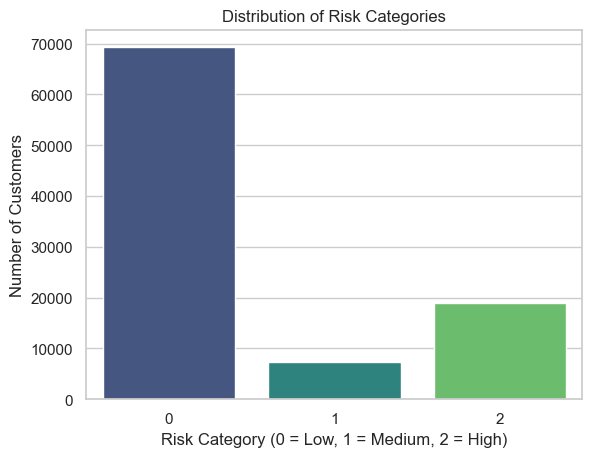

🏷 Customer Risk Tag Distribution: CustomerRiskTag
Low Risk        0.72
Standard Risk   0.27
Fraud Flagged   0.00
Name: proportion, dtype: float64


In [8]:
# ------------------------------------------------------------------------------
# 🛡 Assign Risk Category & Visualize Risk Distribution
# ------------------------------------------------------------------------------

# Assign risk categories (0, 1, 2)
df = categorizer.assign_risk_category(df)

# Confirm updated categories
df["risk_category"].value_counts(normalize=True)

# Plot risk distribution
categorizer.plot_risk_distribution(df)

# ----------------------------------------------------------------------
# 🏷 Assign Descriptive Customer Risk Tags
# ----------------------------------------------------------------------

# Apply descriptive customer risk tags
df = categorizer.assign_customer_risk_tag(df)

# Quick check on tag distribution
tag_summary = df["CustomerRiskTag"].value_counts(normalize=True)
print("🏷 Customer Risk Tag Distribution:", tag_summary)

## 🚦 6️⃣ Generate Binary Risk Label for Predictive Modeling

This step creates the **binary target variable (`is_high_risk`)** for model training:
- **1** = High Risk customer
- **0** = Not High Risk customer

Key actions:
- Generate binary label based on risk category.
- Validate class balance before modeling.

In [9]:
# ------------------------------------------------------------------------------
# 🚦 Generate Binary Target Label (is_high_risk)
# ------------------------------------------------------------------------------

from src.features.proxy_label_engineer import (
    BinaryLabelGenerator,
)  # Import binary label generator

# Instantiate binary label generator
binary_gen = BinaryLabelGenerator()

# Generate binary label
df = binary_gen.generate_binary_label(df)

# Quick class balance check
df["is_high_risk"].value_counts(normalize=True)

is_high_risk
0   0.80
1   0.20
Name: proportion, dtype: float64


## 💾 7️⃣ Save Final Dataset with Risk Labels (Task 5 Ready)

This step saves the **final enriched dataset** with all risk labels into the `/data/processed/` directory for use in **Task 5: Model Training**.

Key actions:
- Save to CSV.
- Confirm successful write.

In [10]:
# ------------------------------------------------------------------------------
# 💾 Save Enriched Dataset with Risk Labels
# ------------------------------------------------------------------------------

# Confirm final columns before saving
print("✅ Final dataset columns:", df.columns.tolist()) # Confirm final columns

# Define output path
output_path = "data/processed/enriched_transactions_with_proxy_labels.csv"

# Save DataFrame
df.to_csv(output_path, index=False)

print(f"✅ Data saved: {output_path}")

✅ Final dataset columns: ['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'Amount', 'Value', 'TransactionStartTime', 'PricingStrategy', 'FraudResult', 'IsSharedAccount', 'Recency', 'Frequency', 'Monetary', 'FraudRisk', 'BehaviorCluster', 'BehavioralVarianceFlag', 'RiskScore', 'risk_category', 'CustomerRiskTag', 'is_high_risk']
✅ Data saved: data/processed/enriched_transactions_with_proxy_labels.csv
